# Notebook Initialization

In [1]:
# %load nb_init.py

from pathlib import Path
import pandas as pd

base_dir = Path.cwd().parent
config_dir = base_dir / "config"
data_dir = base_dir / "data"
docs_dir = base_dir / "docs"
figures_dir = docs_dir / "figures"
models_dir = base_dir / "models"
logs_dir = base_dir / "logs"
images_input_dir = data_dir / "COVID19"
preprocessed_dir = data_dir / "preprocessed"
output_dir = data_dir / "output"

# Directories used to train the CNN (image by image) 
cnn_data_dir = data_dir / "modelling" / "cnn"
cnn_train_dir = cnn_data_dir / "train"
cnn_test_dir = cnn_data_dir / "test"

metadata_file = images_input_dir / "metadata.csv"
labels_file = images_input_dir / "unzip_filenames.csv"
preprocessed_labels_file = preprocessed_dir / "labels.parquet"

feature_extractor_model_file = models_dir / "feature_extractor.tf"

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.getOrCreate()

config_file = config_dir / "tfg.conf"

from pyhocon import ConfigFactory
config = None

def load_config():
    return ConfigFactory.parse_file(config_file)

config = load_config()
    
import sys

if str(base_dir / "src") not in sys.path:
    sys.path.append(str(base_dir / "src"))

%load_ext autoreload

%autoreload 2

In [2]:
spark

In [3]:
from tfg import DataRepository

repo = DataRepository(config=config, base_data_path=data_dir)

# Load datasets

In [4]:
import numpy as np

In [5]:
class_idx = {'CP': 0, 'NCP': 1, 'Normal': 2}
idx_to_class = { v: k for k, v in class_idx.items() }

In [6]:
train_clips = repo.load("train_clips")
train_clips.head(5)

,patient_id,scan_id,label,n_slice,clip_num,clip_start_file,clip_end_file,seq_features,seq_probs
0,0,3131,CP,285,0,CP/0/3131/0000.png,CP/0/3131/0069.png,"[[0.0, 0.0, 2.9882235527038574, 0.0, 0.0, 0.0,...","[[0.995826005935669, 0.002047961810603738, 0.0..."
1,0,3131,CP,285,1,CP/0/3131/0070.png,CP/0/3131/0139.png,"[[0.0, 0.015588469803333282, 2.548190832138061...","[[0.9611499309539795, 0.0388215146958828, 2.85..."
2,0,3131,CP,285,2,CP/0/3131/0140.png,CP/0/3131/0209.png,"[[0.3391307592391968, 0.016530275344848633, 2....","[[0.9554761648178101, 0.04128715768456459, 0.0..."
3,0,3131,CP,285,3,CP/0/3131/0210.png,CP/0/3131/0279.png,"[[0.29484760761260986, 0.0, 1.7729129791259766...","[[0.9988947510719299, 0.00042690912960097194, ..."
4,0,3131,CP,285,4,CP/0/3131/0280.png,CP/0/3131/0284.png,"[[2.112011671066284, 0.0, 3.815093755722046, 0...","[[0.9980648159980774, 0.0014690179377794266, 0..."


In [7]:
def to_single_nparr(arrs):
    return np.array([el.tolist() for el  in arrs.tolist()])

def ohe_label(label):
    ohe_labels = [0, 0, 0]
    ohe_labels[class_idx[label]] = 1
    
    return np.array(ohe_labels)

In [8]:
train_targets = train_clips["label"].apply(ohe_label).values
train_targets = to_single_nparr(train_targets)
train_targets[:5], train_targets[-5:]

(array([[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]]),
 array([[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]]))

In [9]:
train_data = train_clips["seq_features"].apply(to_single_nparr).values
train_data[:1], train_data[-1:]

(array([array([[0.        , 0.        , 2.98822355, ..., 0.72927612, 0.        ,
         0.44937783],
        [0.36093032, 0.        , 4.37772894, ..., 1.30455339, 0.        ,
         1.11693501],
        [0.98390299, 0.        , 3.60125709, ..., 1.25560212, 0.        ,
         1.22812939],
        ...,
        [0.        , 0.06825965, 1.86592245, ..., 0.05172634, 0.        ,
         0.        ],
        [0.81235242, 0.2658385 , 4.02565336, ..., 0.        , 0.56523615,
         0.        ],
        [2.29294705, 0.        , 4.27155209, ..., 1.46142101, 0.        ,
         1.49820328]])], dtype=object),
 array([array([[0.        , 1.02570331, 0.        , ..., 0.        , 0.77238965,
         0.        ],
        [0.        , 1.11100841, 0.        , ..., 0.        , 0.84015405,
         0.        ],
        [0.        , 2.30372715, 0.60316122, ..., 0.        , 1.95132911,
         0.        ],
        ...,
        [0.        , 2.52368426, 0.        , ..., 0.        , 2.12280846,
    

In [10]:
train_data.shape

(6117,)

In [11]:
train_data[0].shape

(70, 32)

In [12]:
num_obs, seq_length, num_feats = train_data.shape[0], train_data[0].shape[0], train_data[0].shape[1]
new_shape = (num_obs, seq_length, num_feats)
new_training_data = np.zeros(new_shape)
new_training_data.shape

(6117, 70, 32)

In [13]:
# With this we make sure that the final data is a single numpy array
for idx, obs in enumerate(train_data):
    if len(obs) < seq_length:
        for feat_idx, feats in enumerate(obs):
            new_training_data[idx][feat_idx] = feats
    else:
        new_training_data[idx] = obs

In [14]:
val_clips = repo.load("val_clips")
val_clips.head(5)

,patient_id,scan_id,label,n_slice,clip_num,clip_start_file,clip_end_file,seq_features,seq_probs
0,4,3505,CP,298,0,CP/4/3505/0000.png,CP/4/3505/0069.png,"[[2.613647699356079, 0.0, 0.9890813827514648, ...","[[0.9998388290405273, 2.6595776034810115e-06, ..."
1,4,3505,CP,298,1,CP/4/3505/0070.png,CP/4/3505/0139.png,"[[3.2934000492095947, 0.0, 5.15690279006958, 0...","[[1.0, 3.73688280319584e-09, 2.112125196962466..."
2,4,3505,CP,298,2,CP/4/3505/0140.png,CP/4/3505/0209.png,"[[3.833109140396118, 0.0, 5.286610126495361, 0...","[[0.9999998807907104, 6.390022377900095e-08, 2..."
3,4,3505,CP,298,3,CP/4/3505/0210.png,CP/4/3505/0279.png,"[[3.43273663520813, 0.0, 0.621675968170166, 0....","[[0.9999997615814209, 2.8103993798822557e-08, ..."
4,4,3505,CP,298,4,CP/4/3505/0280.png,CP/4/3505/0297.png,"[[4.024286270141602, 0.0, 1.0903337001800537, ...","[[0.9956602454185486, 0.0034320885315537453, 0..."


In [15]:
val_targets = val_clips["label"].apply(ohe_label).values
val_targets = to_single_nparr(val_targets)
val_targets[:5], val_targets[-5:]

(array([[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]]),
 array([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]]))

In [16]:
val_data = val_clips["seq_features"].apply(to_single_nparr).values
val_data[:1], val_data[-1:]

(array([array([[2.6136477 , 0.        , 0.98908138, ..., 0.80635095, 0.        ,
         0.83522969],
        [3.08556819, 0.        , 1.16019964, ..., 0.82768691, 0.        ,
         0.94938755],
        [3.13986325, 0.        , 2.20502305, ..., 1.3187505 , 0.        ,
         1.50978446],
        ...,
        [3.3429215 , 0.        , 4.32882261, ..., 1.8979671 , 0.        ,
         2.183213  ],
        [3.63964081, 0.        , 4.41138649, ..., 1.97474813, 0.        ,
         2.31390309],
        [3.54425406, 0.        , 5.61092615, ..., 2.367167  , 0.        ,
         2.77212691]])], dtype=object),
 array([array([[0.        , 0.40822747, 0.        , ..., 0.        , 0.46930605,
         0.        ],
        [0.44518673, 0.14363712, 0.        , ..., 0.        , 0.18813239,
         0.        ],
        [0.74548346, 0.14900705, 0.        , ..., 0.        , 0.20418029,
         0.        ],
        ...,
        [0.22963272, 0.        , 1.32374883, ..., 0.81885922, 0.        ,
    

In [17]:
num_val_obs = val_data.shape[0]
new_val_shape = (num_val_obs, seq_length, num_feats)
new_val_data = np.zeros(new_val_shape)
new_val_data.shape

(744, 70, 32)

In [18]:
# With this we make sure that the final data is a single numpy array
for idx, obs in enumerate(val_data):
    if len(obs) < seq_length:
        for feat_idx, feats in enumerate(obs):
            new_val_data[idx][feat_idx] = feats
    else:
        new_val_data[idx] = obs

# Create model

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [121]:
model = keras.Sequential()

num_recurrent_units = 4
seq_length = 70

model.add(
    layers.Bidirectional(layers.GRU(num_recurrent_units, return_sequences=False), input_shape=(seq_length, num_feats), name="gru_bidirect_1")
)
# model.add(layers.Bidirectional(layers.GRU(num_recurrent_units // 2), name="gru_bidirect_2"))
# model.add(
#     layers.GRU(64, return_sequences=True, input_shape=(seq_length, num_features))
# )
# model.add(layers.GRU(num_features // 2))

# #model.add(layers.GRU(num_recurrent_units // 2, name="gru_bidirect_2"))
# model.add(layers.Bidirectional(layers.GRU(num_recurrent_units // 2), name="gru_bidirect_2"))

model.add(layers.Dense(3))#min(10, num_recurrent_units // 2))
model.add(layers.Dense(3))

model.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_bidirect_1 (Bidirectiona (None, 8)                 912       
_________________________________________________________________
dense_68 (Dense)             (None, 3)                 27        
_________________________________________________________________
dense_69 (Dense)             (None, 3)                 12        
Total params: 951
Trainable params: 951
Non-trainable params: 0
_________________________________________________________________


In [122]:
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['categorical_accuracy'])

In [123]:
fit_history = model.fit(
    x=new_training_data, y=train_targets,
    batch_size=32, epochs=10,
    verbose=1,
    validation_data=(new_val_data, val_targets)
)

Epoch 1/10
192/192 [==============================] - 2s 10ms/step - loss: 3.8321 - categorical_accuracy: 0.4280 - val_loss: 3.3696 - val_categorical_accuracy: 0.1801
Epoch 2/10
192/192 [==============================] - 1s 8ms/step - loss: 5.1497 - categorical_accuracy: 0.1802 - val_loss: 5.6522 - val_categorical_accuracy: 0.1976
Epoch 3/10
192/192 [==============================] - 1s 8ms/step - loss: 4.3759 - categorical_accuracy: 0.2593 - val_loss: 3.6327 - val_categorical_accuracy: 0.3468
Epoch 4/10
192/192 [==============================] - 1s 8ms/step - loss: 3.5856 - categorical_accuracy: 0.3561 - val_loss: 4.1213 - val_categorical_accuracy: 0.4315
Epoch 5/10
192/192 [==============================] - 1s 8ms/step - loss: 1.2265 - categorical_accuracy: 0.5259 - val_loss: 0.9554 - val_categorical_accuracy: 0.5954
Epoch 6/10
192/192 [==============================] - 1s 8ms/step - loss: 0.8674 - categorical_accuracy: 0.6050 - val_loss: 0.8976 - val_categorical_accuracy: 0.6613
Epo

# Evaluation of the different sets

In [80]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(13, 9)})

In [81]:
import numpy as np
import itertools

sns.set_style("whitegrid", {'axes.grid' : False})

# based on answer from https://datascience.stackexchange.com/questions/40067/confusion-matrix-three-classes-python
def plot_confusion_matrix(cm, classes,
                          save_to=None,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontdict={'fontsize' : 26})
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=18)
    plt.yticks(tick_marks, classes, fontsize=18)

    fmt_pct = lambda pct: f"{100 * pct:.2f}%" if normalize else f"{int(100 * pct)}%"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, fmt_pct(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontdict={'fontsize' : 16})

    plt.ylabel('True label', fontdict={'fontsize' : 22})
    plt.xlabel('Predicted label', fontdict={'fontsize' : 22})
    plt.tight_layout()
    
    if save_to:
        plt.savefig(save_to)

In [82]:
def print_metrics(dataset, true_labels, pred_labels):
    prec, rec, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average="weighted")
    print(f"{dataset} F1 Score: {100 * f1: .2f}%")
    print(f"{dataset} Precision: {100 * prec: .2f}%")
    print(f"{dataset} Recall: {100 * rec: .2f}%")

In [83]:
class_to_idx = {'CP': 0, 'NCP': 1, 'Normal': 2}
idx_to_class = { v: k for k, v in class_to_idx.items() }
class_labels = [k for k in class_to_idx.keys()]

## Training

192/192 [==============================] - 1s 3ms/step
Normalized confusion matrix
[[0.94528875 0.05036908 0.00434216]
 [0.07061503 0.89567198 0.03371298]
 [0.3409512  0.27300803 0.38604077]]


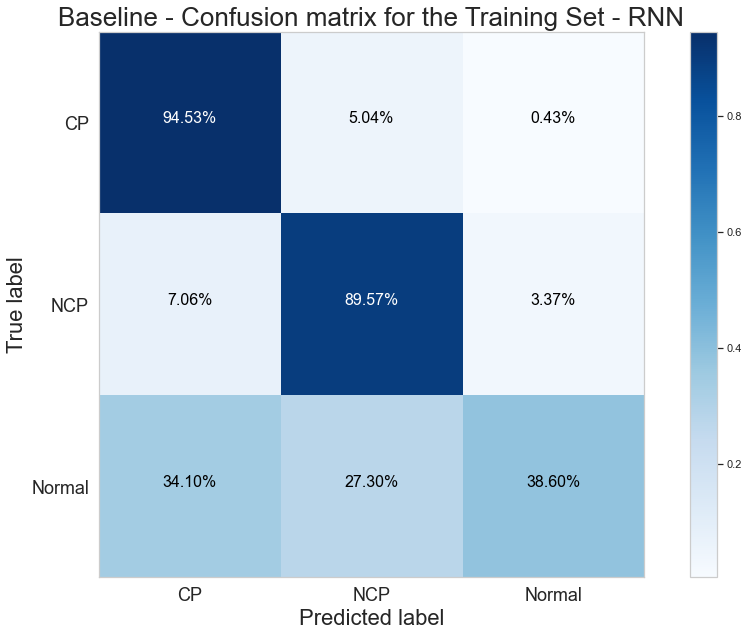

In [131]:
raw_train_preds = model.predict(new_training_data, verbose=1)
train_preds = raw_train_preds.argmax(axis=1)
train_true = train_targets.argmax(axis=1)

train_cm = confusion_matrix(train_true, train_preds)

plot_confusion_matrix(
    train_cm,
    classes=class_labels,
    title='Baseline - Confusion matrix for the Training Set - RNN',
    save_to=figures_dir / "models" / "rnn_feats" / f"train_conf_matrix.png")

## Validation

24/24 [==============================] - 0s 3ms/step
Normalized confusion matrix
[[0.96271186 0.03728814 0.        ]
 [0.09854015 0.8649635  0.03649635]
 [0.39428571 0.32571429 0.28      ]]


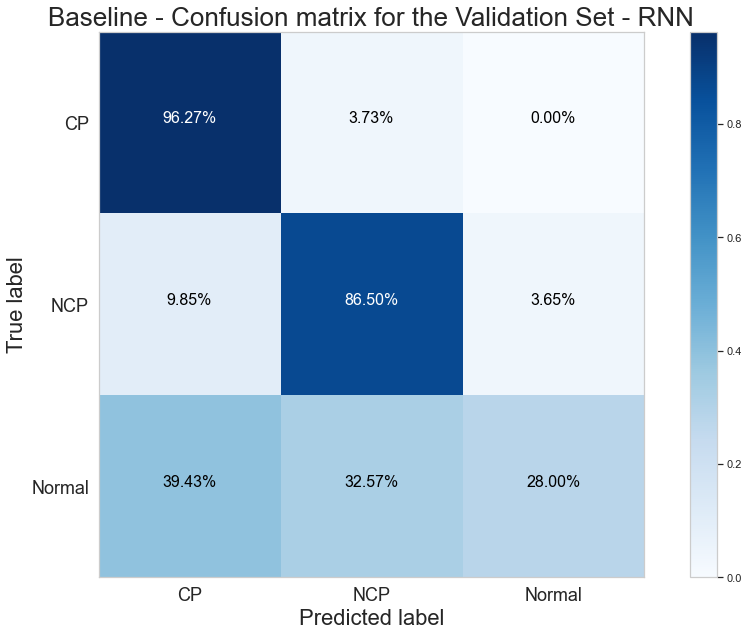

In [132]:
raw_val_preds = model.predict(new_val_data, verbose=1)
val_preds = raw_val_preds.argmax(axis=1)
val_true = val_targets.argmax(axis=1)

val_cm = confusion_matrix(val_true, val_preds)

plot_confusion_matrix(
    val_cm,
    classes=class_labels,
    title='Baseline - Confusion matrix for the Validation Set - RNN',
    save_to=figures_dir / "models" / "rnn_feats" / f"val_conf_matrix.png")